In [139]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [140]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades = oportunidades.dropna()
oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,2016,NaT,0,USD,13200.0,USD,6422400.6,Closed Won,Prod_Category_A_None,1.000000
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,12194000.0,JPY,12194000.0,Closed Won,Prod_Category_A_None,111.229165
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,2016,NaT,0,JPY,11959500.0,JPY,11959500.0,Closed Won,Prod_Category_A_None,111.229165
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,2016,NaT,0,JPY,17537000.0,JPY,17537000.0,Closed Won,Prod_Category_A_None,111.229477


In [141]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None,1.0


In [142]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.000000,2.232794e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,NaT,0,USD,11961.6,USD,0.0,Closed Won,Prod_Category_A_None,1.000000,2.232794e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,NaT,1,JPY,38976000.0,JPY,38976000.0,Closed Lost,Prod_Category_A_None,111.229550,5.688996e+07
9721,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,NaT,1,JPY,56028000.0,JPY,56028000.0,Closed Lost,Prod_Category_A_None,111.229326,5.688996e+07
9722,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,NaT,0,JPY,7660800.0,JPY,7660800.0,Closed Lost,Prod_Category_A_None,111.231449,5.688996e+07
9723,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,NaT,0,JPY,825000.0,JPY,825000.0,Closed Won,Prod_Category_A_None,111.230206,5.688996e+07


In [143]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04


In [144]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Moneda_Convertida,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,1.0,2.232794e+06,1.534896e+06,2.250980e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9721,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9722,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06
9723,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,1.0,3.610676e+06,3.498250e+04,2.951944e+06


In [145]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')

In [146]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.250980e+06,1.000000,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,1.042592e+06,2.951944e+06,1.413202,0,0,0,0,1,0,0


In [147]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.250980e+06,1.000000,0,0,0,0,0,1,0,2.245889e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.250980e+06,1.000000,0,0,0,0,1,0,0,2.245889e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9721,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9722,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06
9723,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,8.201907e+05,0.884131,0,0,0,0,1,0,0,4.164458e+06


In [148]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,1.000000,0,0,0,0,1,0,0,2.245889e+06,69490.525
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.884131,0,0,0,0,1,0,0,8.585832e+05,69490.525
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.884131,0,0,0,0,1,0,0,1.240120e+06,69490.525
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,1.000000,0,0,0,0,0,1,0,9.806871e+05,69490.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2197.250
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,369.600
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,2274.300
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,1.000000,0,0,0,0,1,0,0,1.079523e+05,3456.000


In [149]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,8.585832e+05,69490.525,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.240120e+06,69490.525,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,69490.525,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.079523e+05,2197.250,1,0,0,0,0,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.079523e+05,369.600,1,0,0,0,0,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.079523e+05,2274.300,1,0,0,0,0,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.079523e+05,3456.000,1,0,0,0,0,0,0


In [150]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [151]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Año_Por_Mes'] = oportunidades['Opportunity_Created_Year'] \
    * oportunidades['Opportunity_Created_Month']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,1,0,0,0,0,2015,12,24180
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,1,0,0,0,0,2016,4,8064
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,1,0,0,0,0,0,0,2017,12,24204
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,1,0,0,0,0,0,0,2018,1,2018
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,1,2017,6,12102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,1,0,0,2017,12,24204
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,1,0,0,2018,3,6054
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,1,0,0,2018,4,8072
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,1,0,0,2018,6,12108


In [152]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
    'objective':'reg:logistic',
    'max_depth':7,
    'n_estimators':450,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.001,
    #'gamma':0.2
}

params2 = {
    'objective':'reg:logistic',
    'max_depth':8,
    'n_estimators':350,
    'colsample_bytree':0.4,
    'subsample':0.6,
    'learning_rate':0.02,
    'alpha':0.01,
    #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], alpha = params2['alpha'], n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']
oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})
# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_train = x_train.reset_index()
#x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
#x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Amount'] = (x_train['Total_Amount'] / x_train['Encoding_Moneda']) 
x_train['Total_Taxable_Amount'] = (x_train['Total_Taxable_Amount'] / x_train['Encoding_Moneda']) 
x_train['Diferencia_Amounts'] = (x_train['Total_Amount'] - x_train['Total_Taxable_Amount'])
x_train = x_train.drop(columns = ['Encoding_Moneda'])
#x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
#x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

<ipython-input-152-3d616968df79>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [153]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

0:	learn: 0.4914826	total: 6.75ms	remaining: 6.74s
1:	learn: 0.4896876	total: 12.3ms	remaining: 6.12s
2:	learn: 0.4878240	total: 15ms	remaining: 4.99s
3:	learn: 0.4862149	total: 19.7ms	remaining: 4.91s
4:	learn: 0.4845170	total: 23.4ms	remaining: 4.66s
5:	learn: 0.4829833	total: 29.3ms	remaining: 4.84s
6:	learn: 0.4816979	total: 32.5ms	remaining: 4.61s
7:	learn: 0.4799968	total: 38.5ms	remaining: 4.78s
8:	learn: 0.4783648	total: 42.6ms	remaining: 4.7s
9:	learn: 0.4767507	total: 47ms	remaining: 4.65s
10:	learn: 0.4752559	total: 50.2ms	remaining: 4.51s
11:	learn: 0.4737678	total: 52.8ms	remaining: 4.35s
12:	learn: 0.4721631	total: 56.7ms	remaining: 4.31s
13:	learn: 0.4707460	total: 59.7ms	remaining: 4.2s
14:	learn: 0.4693577	total: 62.4ms	remaining: 4.09s
15:	learn: 0.4679855	total: 65.9ms	remaining: 4.05s
16:	learn: 0.4665272	total: 71.1ms	remaining: 4.11s
17:	learn: 0.4650487	total: 78.4ms	remaining: 4.28s
18:	learn: 0.4636990	total: 85.8ms	remaining: 4.43s
19:	learn: 0.4624056	total: 

168:	learn: 0.3861556	total: 1.19s	remaining: 5.86s
169:	learn: 0.3860186	total: 1.2s	remaining: 5.85s
170:	learn: 0.3858553	total: 1.21s	remaining: 5.85s
171:	learn: 0.3857380	total: 1.21s	remaining: 5.84s
172:	learn: 0.3854707	total: 1.22s	remaining: 5.84s
173:	learn: 0.3852538	total: 1.23s	remaining: 5.83s
174:	learn: 0.3849662	total: 1.24s	remaining: 5.84s
175:	learn: 0.3847304	total: 1.25s	remaining: 5.84s
176:	learn: 0.3845849	total: 1.26s	remaining: 5.85s
177:	learn: 0.3844501	total: 1.27s	remaining: 5.85s
178:	learn: 0.3842748	total: 1.27s	remaining: 5.84s
179:	learn: 0.3841570	total: 1.28s	remaining: 5.84s
180:	learn: 0.3839917	total: 1.29s	remaining: 5.84s
181:	learn: 0.3838681	total: 1.3s	remaining: 5.84s
182:	learn: 0.3837556	total: 1.31s	remaining: 5.84s
183:	learn: 0.3835904	total: 1.31s	remaining: 5.83s
184:	learn: 0.3834163	total: 1.32s	remaining: 5.81s
185:	learn: 0.3832045	total: 1.33s	remaining: 5.8s
186:	learn: 0.3830387	total: 1.33s	remaining: 5.79s
187:	learn: 0.3

347:	learn: 0.3655906	total: 2.58s	remaining: 4.84s
348:	learn: 0.3655229	total: 2.59s	remaining: 4.83s
349:	learn: 0.3654358	total: 2.6s	remaining: 4.82s
350:	learn: 0.3653646	total: 2.6s	remaining: 4.82s
351:	learn: 0.3652721	total: 2.61s	remaining: 4.81s
352:	learn: 0.3651411	total: 2.62s	remaining: 4.8s
353:	learn: 0.3650711	total: 2.63s	remaining: 4.8s
354:	learn: 0.3649092	total: 2.63s	remaining: 4.79s
355:	learn: 0.3648527	total: 2.64s	remaining: 4.78s
356:	learn: 0.3647663	total: 2.65s	remaining: 4.78s
357:	learn: 0.3646611	total: 2.66s	remaining: 4.77s
358:	learn: 0.3646087	total: 2.67s	remaining: 4.76s
359:	learn: 0.3645465	total: 2.67s	remaining: 4.75s
360:	learn: 0.3644950	total: 2.68s	remaining: 4.74s
361:	learn: 0.3644560	total: 2.69s	remaining: 4.73s
362:	learn: 0.3643636	total: 2.69s	remaining: 4.72s
363:	learn: 0.3643175	total: 2.7s	remaining: 4.72s
364:	learn: 0.3642880	total: 2.71s	remaining: 4.71s
365:	learn: 0.3641766	total: 2.71s	remaining: 4.7s
366:	learn: 0.3640

525:	learn: 0.3534603	total: 3.97s	remaining: 3.58s
526:	learn: 0.3533743	total: 3.98s	remaining: 3.58s
527:	learn: 0.3532688	total: 3.99s	remaining: 3.57s
528:	learn: 0.3531511	total: 4s	remaining: 3.56s
529:	learn: 0.3530761	total: 4s	remaining: 3.55s
530:	learn: 0.3530522	total: 4.01s	remaining: 3.54s
531:	learn: 0.3530080	total: 4.02s	remaining: 3.54s
532:	learn: 0.3529172	total: 4.02s	remaining: 3.53s
533:	learn: 0.3528767	total: 4.03s	remaining: 3.52s
534:	learn: 0.3528160	total: 4.04s	remaining: 3.51s
535:	learn: 0.3527723	total: 4.05s	remaining: 3.5s
536:	learn: 0.3527127	total: 4.05s	remaining: 3.5s
537:	learn: 0.3526597	total: 4.06s	remaining: 3.48s
538:	learn: 0.3525925	total: 4.07s	remaining: 3.48s
539:	learn: 0.3525531	total: 4.07s	remaining: 3.47s
540:	learn: 0.3524839	total: 4.08s	remaining: 3.46s
541:	learn: 0.3523941	total: 4.09s	remaining: 3.45s
542:	learn: 0.3522803	total: 4.09s	remaining: 3.44s
543:	learn: 0.3522241	total: 4.1s	remaining: 3.43s
544:	learn: 0.3521870

699:	learn: 0.3442108	total: 5.17s	remaining: 2.21s
700:	learn: 0.3441661	total: 5.17s	remaining: 2.21s
701:	learn: 0.3441307	total: 5.18s	remaining: 2.2s
702:	learn: 0.3440745	total: 5.19s	remaining: 2.19s
703:	learn: 0.3439816	total: 5.2s	remaining: 2.19s
704:	learn: 0.3439334	total: 5.21s	remaining: 2.18s
705:	learn: 0.3438804	total: 5.22s	remaining: 2.17s
706:	learn: 0.3438213	total: 5.22s	remaining: 2.16s
707:	learn: 0.3437195	total: 5.23s	remaining: 2.16s
708:	learn: 0.3436660	total: 5.24s	remaining: 2.15s
709:	learn: 0.3436062	total: 5.25s	remaining: 2.14s
710:	learn: 0.3435469	total: 5.26s	remaining: 2.14s
711:	learn: 0.3434673	total: 5.26s	remaining: 2.13s
712:	learn: 0.3434407	total: 5.27s	remaining: 2.12s
713:	learn: 0.3434137	total: 5.28s	remaining: 2.11s
714:	learn: 0.3433747	total: 5.28s	remaining: 2.11s
715:	learn: 0.3433091	total: 5.29s	remaining: 2.1s
716:	learn: 0.3432611	total: 5.3s	remaining: 2.09s
717:	learn: 0.3432037	total: 5.3s	remaining: 2.08s
718:	learn: 0.343

871:	learn: 0.3359043	total: 6.37s	remaining: 935ms
872:	learn: 0.3358600	total: 6.38s	remaining: 928ms
873:	learn: 0.3358029	total: 6.38s	remaining: 921ms
874:	learn: 0.3357550	total: 6.39s	remaining: 913ms
875:	learn: 0.3357151	total: 6.4s	remaining: 906ms
876:	learn: 0.3356882	total: 6.4s	remaining: 898ms
877:	learn: 0.3356484	total: 6.41s	remaining: 891ms
878:	learn: 0.3356267	total: 6.42s	remaining: 883ms
879:	learn: 0.3356071	total: 6.42s	remaining: 876ms
880:	learn: 0.3355738	total: 6.43s	remaining: 869ms
881:	learn: 0.3355184	total: 6.44s	remaining: 862ms
882:	learn: 0.3354707	total: 6.45s	remaining: 854ms
883:	learn: 0.3354353	total: 6.45s	remaining: 847ms
884:	learn: 0.3353941	total: 6.46s	remaining: 839ms
885:	learn: 0.3353553	total: 6.47s	remaining: 832ms
886:	learn: 0.3353239	total: 6.47s	remaining: 825ms
887:	learn: 0.3352723	total: 6.48s	remaining: 817ms
888:	learn: 0.3352277	total: 6.49s	remaining: 810ms
889:	learn: 0.3351994	total: 6.49s	remaining: 802ms
890:	learn: 0.

In [154]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades["Moneda_Convertida"] = (oportunidades['ASP'] / oportunidades['ASP_(converted)'])
oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Moneda_Convertida
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None,0.884089
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None,0.884100
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None,0.884102
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None,0.884089
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None,0.884100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,30000.0,JPY,73200.0,Prod_Category_A_None,NaN
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,Q2,2019,NaT,0,JPY,43200.0,JPY,73200.0,Prod_Category_A_None,111.228519
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,Q3,2020,NaT,12,USD,4079928.6,USD,4079928.6,Prod_Category_A_None,1.000000
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,Q3,2019,NaT,0,JPY,5068800.0,JPY,5068800.0,Prod_Category_A_None,111.229081


In [155]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'Moneda_Convertida' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades['Opportunity_Created_Month'] = oportunidades['Opportunity_Created_Date'].dt.month
oportunidades['Año_Por_Mes'] = oportunidades['Opportunity_Created_Year'] * oportunidades['Opportunity_Created_Month']
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Opportunity_Created_Month,Año_Por_Mes
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,0,0,0,0,0,0,1.347805e+07,2019,4,8076
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,0,0,0,0,0,0,1.347805e+07,2019,4,8076
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_3499,...,0,0,0,0,0,0,1.347805e+07,2019,1,2019
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Account_Name_533,Opportunity_Name_4292,...,0,0,0,0,0,0,1.347805e+07,2019,2,4038
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Account_Name_263,Opportunity_Name_2981,...,0,0,0,0,0,0,1.347805e+07,2019,3,6057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Account_Name_1533,Opportunity_Name_9046,...,0,0,0,1,0,0,3.300000e+05,2019,3,6057
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Account_Name_1377,Opportunity_Name_12892,...,0,1,0,0,0,0,1.351350e+08,2019,4,8076
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Account_Name_1508,Opportunity_Name_278,...,0,1,0,0,0,0,1.800000e+04,2019,2,4038
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Account_Name_1240,Opportunity_Name_313,...,0,1,0,0,0,0,1.800000e+04,2019,3,6057


In [156]:
#Hacemos el groupby

# std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'TRF':'std'})
# std_deviation_amounts.columns = ['TRF_Std']
# std_deviation_amounts = std_deviation_amounts.reset_index()
x_test = oportunidades.groupby('Opportunity_ID').agg({'Año_Por_Mes' : 'mean',\
                                                      'Encoding_Moneda':'mean', 'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'mean', 'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean'})
x_test = x_test.reset_index()
#x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
#x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
#x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['Total_Amount'] = (x_test['Total_Amount'] / x_test['Encoding_Moneda']) 
x_test['Total_Taxable_Amount'] = (x_test['Total_Taxable_Amount'] / x_test['Encoding_Moneda']) 
x_test['Diferencia_Amounts'] = (x_test['Total_Amount'] - x_test['Total_Taxable_Amount'])
x_test = x_test.drop(['Encoding_Moneda'], axis='columns')
#x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Año_Por_Mes,Total_Amount,Total_Taxable_Amount,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,...,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Diferencia_Amounts
Opportunity_ID,,,,,,,,,,,,,,,,,,,,,
10689,8076,4.155852e+05,4.155852e+05,2.067734e+05,2.488654e+05,1.719364e+05,1,0,0,0,...,0,0,0,5.393987e+06,1,0,0,0,0,0.0
10690,8076,8.571239e+05,8.571239e+05,2.067734e+05,2.488654e+05,1.719364e+05,1,0,0,0,...,0,0,0,3.325469e+06,1,0,0,0,0,0.0
10691,8076,2.103750e+04,2.103750e+04,1.927213e+06,1.379371e+06,1.084468e+06,1,0,0,0,...,0,0,0,2.631901e+06,0,0,1,0,0,0.0
10692,8076,2.169106e+06,2.169106e+06,1.927213e+06,1.192205e+06,5.801348e+06,0,0,0,1,...,0,0,0,5.979980e+06,1,0,0,0,0,0.0
10693,8076,5.752500e+03,5.752500e+03,1.927213e+06,1.192205e+06,2.007641e+05,1,0,0,0,...,0,0,0,1.387158e+05,1,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,8076,1.477500e+05,1.477500e+05,2.067734e+05,1.305692e+05,1.719364e+05,1,0,0,0,...,0,1,0,3.638642e+05,1,0,0,0,0,0.0
12365,8076,4.505490e+04,4.505490e+04,1.927213e+06,2.550403e+06,9.390888e+05,1,0,0,0,...,0,0,0,5.979980e+06,0,0,1,0,0,0.0
12366,8076,1.001220e+05,1.001220e+05,1.927213e+06,2.550403e+06,9.390888e+05,1,0,0,0,...,0,0,0,5.979980e+06,0,0,1,0,0,0.0


In [157]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.32385158, 0.281443  , 0.69731266, ..., 0.45168766, 0.47737825,
       0.28822192])

In [158]:
predictions

array([0.32074636, 0.26762104, 0.7133474 , ..., 0.40230948, 0.44403896,
       0.31748796], dtype=float32)

In [159]:
predictions2

array([0.31412   , 0.2754619 , 0.7101271 , ..., 0.3984083 , 0.50508845,
       0.33267197], dtype=float32)

In [160]:
predictions3

array([0.33668837, 0.30124605, 0.66846343, ..., 0.5543452 , 0.48300731,
       0.21450582])

In [161]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.323852
1,10690,0.281443
2,10691,0.697313
3,10692,0.127571
4,10693,0.862118
...,...,...
1562,12364,0.707247
1563,12365,0.532734
1564,12366,0.451688
1565,12367,0.477378


In [162]:
df.to_csv("Predicciones.csv", index=False)

In [163]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

0:	learn: 0.4905423	total: 8.98ms	remaining: 8.97s
1:	learn: 0.4886249	total: 14.2ms	remaining: 7.11s
2:	learn: 0.4868509	total: 17.7ms	remaining: 5.88s
3:	learn: 0.4852492	total: 20.9ms	remaining: 5.2s
4:	learn: 0.4834332	total: 23.9ms	remaining: 4.76s
5:	learn: 0.4815907	total: 26ms	remaining: 4.3s
6:	learn: 0.4800488	total: 29.2ms	remaining: 4.15s
7:	learn: 0.4784848	total: 32.3ms	remaining: 4.01s
8:	learn: 0.4767668	total: 34.2ms	remaining: 3.76s
9:	learn: 0.4751970	total: 36.1ms	remaining: 3.58s
10:	learn: 0.4737519	total: 39.3ms	remaining: 3.53s
11:	learn: 0.4722724	total: 43.1ms	remaining: 3.54s
12:	learn: 0.4708606	total: 45ms	remaining: 3.42s
13:	learn: 0.4693013	total: 47.3ms	remaining: 3.33s
14:	learn: 0.4678777	total: 49.9ms	remaining: 3.28s
15:	learn: 0.4664486	total: 52ms	remaining: 3.19s
16:	learn: 0.4653807	total: 53.4ms	remaining: 3.09s
17:	learn: 0.4640531	total: 57.3ms	remaining: 3.13s
18:	learn: 0.4627281	total: 59.9ms	remaining: 3.09s
19:	learn: 0.4613947	total: 61

164:	learn: 0.3823416	total: 783ms	remaining: 3.96s
165:	learn: 0.3821217	total: 789ms	remaining: 3.96s
166:	learn: 0.3818805	total: 795ms	remaining: 3.97s
167:	learn: 0.3816919	total: 803ms	remaining: 3.98s
168:	learn: 0.3814374	total: 807ms	remaining: 3.97s
169:	learn: 0.3813021	total: 812ms	remaining: 3.97s
170:	learn: 0.3811120	total: 820ms	remaining: 3.98s
171:	learn: 0.3810044	total: 825ms	remaining: 3.97s
172:	learn: 0.3807212	total: 831ms	remaining: 3.97s
173:	learn: 0.3804392	total: 837ms	remaining: 3.97s
174:	learn: 0.3802219	total: 842ms	remaining: 3.97s
175:	learn: 0.3799889	total: 849ms	remaining: 3.97s
176:	learn: 0.3797878	total: 854ms	remaining: 3.97s
177:	learn: 0.3796436	total: 860ms	remaining: 3.97s
178:	learn: 0.3794426	total: 867ms	remaining: 3.97s
179:	learn: 0.3792680	total: 872ms	remaining: 3.97s
180:	learn: 0.3790837	total: 877ms	remaining: 3.97s
181:	learn: 0.3789449	total: 881ms	remaining: 3.96s
182:	learn: 0.3787987	total: 886ms	remaining: 3.95s
183:	learn: 

330:	learn: 0.3599371	total: 1.76s	remaining: 3.55s
331:	learn: 0.3598292	total: 1.76s	remaining: 3.55s
332:	learn: 0.3597740	total: 1.77s	remaining: 3.54s
333:	learn: 0.3597210	total: 1.78s	remaining: 3.54s
334:	learn: 0.3595697	total: 1.78s	remaining: 3.54s
335:	learn: 0.3594827	total: 1.79s	remaining: 3.53s
336:	learn: 0.3592984	total: 1.79s	remaining: 3.53s
337:	learn: 0.3592063	total: 1.8s	remaining: 3.52s
338:	learn: 0.3590851	total: 1.81s	remaining: 3.52s
339:	learn: 0.3589466	total: 1.81s	remaining: 3.52s
340:	learn: 0.3588131	total: 1.82s	remaining: 3.51s
341:	learn: 0.3587736	total: 1.82s	remaining: 3.51s
342:	learn: 0.3587278	total: 1.83s	remaining: 3.51s
343:	learn: 0.3586024	total: 1.84s	remaining: 3.5s
344:	learn: 0.3585028	total: 1.84s	remaining: 3.5s
345:	learn: 0.3584129	total: 1.85s	remaining: 3.5s
346:	learn: 0.3583382	total: 1.85s	remaining: 3.49s
347:	learn: 0.3582546	total: 1.86s	remaining: 3.48s
348:	learn: 0.3581940	total: 1.86s	remaining: 3.48s
349:	learn: 0.35

501:	learn: 0.3464912	total: 2.74s	remaining: 2.72s
502:	learn: 0.3464117	total: 2.75s	remaining: 2.71s
503:	learn: 0.3463708	total: 2.75s	remaining: 2.71s
504:	learn: 0.3462945	total: 2.76s	remaining: 2.7s
505:	learn: 0.3462452	total: 2.76s	remaining: 2.7s
506:	learn: 0.3461585	total: 2.77s	remaining: 2.69s
507:	learn: 0.3460838	total: 2.78s	remaining: 2.69s
508:	learn: 0.3459938	total: 2.78s	remaining: 2.68s
509:	learn: 0.3459284	total: 2.79s	remaining: 2.68s
510:	learn: 0.3458940	total: 2.79s	remaining: 2.67s
511:	learn: 0.3458603	total: 2.8s	remaining: 2.67s
512:	learn: 0.3457564	total: 2.8s	remaining: 2.66s
513:	learn: 0.3457508	total: 2.81s	remaining: 2.65s
514:	learn: 0.3456925	total: 2.81s	remaining: 2.65s
515:	learn: 0.3456151	total: 2.82s	remaining: 2.64s
516:	learn: 0.3455661	total: 2.82s	remaining: 2.64s
517:	learn: 0.3455070	total: 2.83s	remaining: 2.63s
518:	learn: 0.3454251	total: 2.84s	remaining: 2.63s
519:	learn: 0.3453807	total: 2.84s	remaining: 2.62s
520:	learn: 0.34

675:	learn: 0.3353403	total: 3.71s	remaining: 1.78s
676:	learn: 0.3352534	total: 3.71s	remaining: 1.77s
677:	learn: 0.3352194	total: 3.72s	remaining: 1.77s
678:	learn: 0.3351949	total: 3.73s	remaining: 1.76s
679:	learn: 0.3351451	total: 3.73s	remaining: 1.76s
680:	learn: 0.3350782	total: 3.74s	remaining: 1.75s
681:	learn: 0.3350246	total: 3.74s	remaining: 1.75s
682:	learn: 0.3349635	total: 3.75s	remaining: 1.74s
683:	learn: 0.3349102	total: 3.75s	remaining: 1.73s
684:	learn: 0.3348073	total: 3.76s	remaining: 1.73s
685:	learn: 0.3347757	total: 3.77s	remaining: 1.73s
686:	learn: 0.3347383	total: 3.77s	remaining: 1.72s
687:	learn: 0.3346700	total: 3.78s	remaining: 1.71s
688:	learn: 0.3346138	total: 3.79s	remaining: 1.71s
689:	learn: 0.3345882	total: 3.79s	remaining: 1.7s
690:	learn: 0.3345250	total: 3.8s	remaining: 1.7s
691:	learn: 0.3344646	total: 3.8s	remaining: 1.69s
692:	learn: 0.3343712	total: 3.81s	remaining: 1.69s
693:	learn: 0.3343386	total: 3.81s	remaining: 1.68s
694:	learn: 0.33

843:	learn: 0.3259847	total: 4.68s	remaining: 865ms
844:	learn: 0.3259337	total: 4.68s	remaining: 859ms
845:	learn: 0.3258950	total: 4.69s	remaining: 854ms
846:	learn: 0.3258515	total: 4.7s	remaining: 849ms
847:	learn: 0.3258046	total: 4.7s	remaining: 843ms
848:	learn: 0.3257631	total: 4.71s	remaining: 838ms
849:	learn: 0.3257100	total: 4.72s	remaining: 833ms
850:	learn: 0.3256624	total: 4.72s	remaining: 827ms
851:	learn: 0.3256020	total: 4.73s	remaining: 822ms
852:	learn: 0.3255391	total: 4.74s	remaining: 817ms
853:	learn: 0.3254869	total: 4.75s	remaining: 811ms
854:	learn: 0.3254613	total: 4.75s	remaining: 806ms
855:	learn: 0.3253890	total: 4.76s	remaining: 800ms
856:	learn: 0.3253288	total: 4.76s	remaining: 795ms
857:	learn: 0.3252937	total: 4.77s	remaining: 789ms
858:	learn: 0.3252600	total: 4.78s	remaining: 784ms
859:	learn: 0.3252203	total: 4.78s	remaining: 778ms
860:	learn: 0.3251586	total: 4.79s	remaining: 773ms
861:	learn: 0.3251107	total: 4.79s	remaining: 767ms
862:	learn: 0.

In [164]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (xg_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+cat_reg.predict(division_x_test)) / 3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

In [165]:
print("Accuracy1 = " + str(accuracy1) + " ; LogLoss1 = " + str(log_loss1) \
      + "\nAccuracy2 = " + str(accuracy2) + " ; LogLoss2 = " + str(log_loss2)\
     + "\nAccuracy3 = " + str(accuracy3) + " ; LogLoss3 = " + str(log_loss3)
     + "\nAccuracy4 = " + str(accuracy4) + " ; LogLoss4 = " + str(log_loss4))

Accuracy1 = 0.7888052681091251 ; LogLoss1 = 0.44116475297837243
Accuracy2 = 0.7869238005644402 ; LogLoss2 = 0.44029808988941876
Accuracy3 = 0.7756349952963312 ; LogLoss3 = 0.44669464451087654
Accuracy4 = 0.79068673565381 ; LogLoss4 = 0.43607110889654255


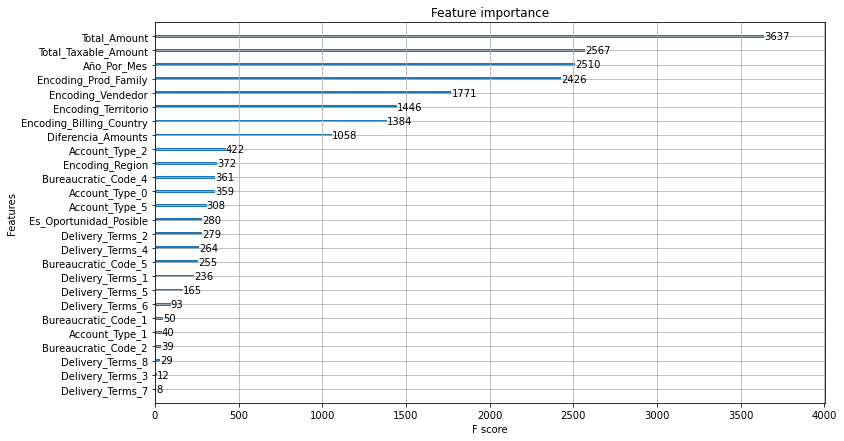

In [166]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)